# Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns, keras
sns.set(style='white')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adagrad, SGD, Adam
from keras import regularizers
from keras.layers import dot, add, Layer
from keras.callbacks import ModelCheckpoint

np.set_printoptions(precision=4, suppress=True, linewidth=100)

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


Using TensorFlow backend.


# Data Preview

In [0]:
ratings = pd.read_csv('https://storage.googleapis.com/allianz-course/data/ratings.csv')
movies = pd.read_csv('https://storage.googleapis.com/allianz-course/data/movies.csv')

In [3]:
print(movies.shape)
movies.head()

(9125, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
print(ratings.rating.describe(), '\n')
print(ratings.rating.value_counts())

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64 

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64


## Observations
* rating的分數介於 0.5 ~ 5分, 最小差距為0.5

# Encode

In [0]:
# Fit user id and movie id
uid_enc, mid_enc = LabelEncoder(), LabelEncoder()
uid_enc.fit(ratings.userId)
mid_enc.fit(movies.movieId)

# Encode user id and movie id to indexed real value
ratings["userId"] = uid_enc.transform(ratings.userId)
ratings["movieId"] = mid_enc.transform(ratings.movieId)
movies["movieId"] = mid_enc.transform(movies.movieId)

# Dictionary of movie id and title
mid_map = pd.Series(dict(zip(movies.movieId, movies.title)))

# Number of users, number of movies
n_users, n_movies = len(uid_enc.classes_), len(mid_enc.classes_)

# Split Train, Test Data
* 以4分為閥值, 4分以上為positive, 未滿4分為negative
* 每個user分positive, negative兩部分, 各取30%到valid data

In [0]:
def split_ratings(data, pos_thres=4, test_ratio=0.3):
    """依照test_ratio切割movielens train test資料"""
    tr, te = [], []
    for u, df in data.groupby("userId"):
        if len(df) < 5: continue

        pos, neg = df.query("rating >= {}".format(pos_thres)), df.query("rating < {}".format(pos_thres))
        # Split positive part
        pos_len = int(len(pos) * (1 - test_ratio))
        tr_pos = pos[:pos_len]
        te_pos = pos[pos_len:]
        # Split negative part
        neg_len = int(len(neg) * (1 - test_ratio))
        tr_neg = neg[:neg_len]
        te_neg = neg[neg_len:]

        tr.append(tr_pos.append(tr_neg))
        te.append(te_pos.append(te_neg))
    return pd.concat(tr, ignore_index=True), pd.concat(te, ignore_index=True)

tr, te = split_ratings(ratings, 4, .3)

# Make Rating Matrix (Interaction Between Users and Movies)

In [9]:
tr_rating_mat = np.zeros((n_users, n_movies))
# Valid data rating matrix
te_rating_mat = np.zeros((n_users, n_movies))

# Train rating matrix
for idx, r in tr.iterrows():
    tr_rating_mat[int(r.userId), int(r.movieId)] = r.rating
# Valid rating matrix    
for idx, r in te.iterrows():
    te_rating_mat[int(r.userId), int(r.movieId)] = r.rating
    
print('Shape of train interaction matrix: ', tr_rating_mat.shape)
print(tr_rating_mat, '\n')
print('Shape of test interaction matrix: ', te_rating_mat.shape)
print(te_rating_mat)

Shape of train interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]] 

Shape of test interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Transformed Data

In [10]:
print( tr.head() )
print()
print( te.head() )

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Model of Matrix Factorization

## Build Model Function

In [11]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    # Bias terms
    b_user = Flatten()(Embedding(n_users, 1, 
                                 embeddings_initializer='glorot_uniform', 
                                 name='b_user')(inp_user))
    b_movie = Flatten()(Embedding(n_movies, 1, 
                                  embeddings_initializer='glorot_uniform', 
                                  name='b_movie')(inp_movie))
    b_global = Flatten()(Embedding(1, 1, 
                                   embeddings_initializer='glorot_uniform', 
                                   name='b_global')(inp_global))
    # Implements the formulation
    nets = dot([emb_user, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 20

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)
model_mf.compile(optimizer=Adagrad(lr=0.1), loss='mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
emb_user (Embedding)            (None, 1, 16)        10736       input_1[0][0]                    
__________________________________________________________________________________________________
emb_movie (Embedding)           (None, 1, 16)        146000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (I

# Training

## Prepare Data for Model

In [0]:
tr_x = [tr.userId[:, None], 
        tr.movieId[:, None], 
        np.zeros([len(tr), 1])]
tr_y = tr.rating[:, None]
# -----------------------------------------------------------------------
te_x = [te.userId[:, None],
        te.movieId[:, None],
        np.zeros([len(te), 1])]
te_y = te.rating[:, None]

## Use Callback Function
* keras.callbacks.ModelCheckpoint: 只存檔最好的結果, 是另一種防止overfitting的方式
    * save_best_only = True

Train on 69399 samples, validate on 30605 samples
Epoch 1/20
69399/69399 [==============================] - 5s 65us/step - loss: 1.7733 - val_loss: 1.0743
Epoch 2/20
69399/69399 [==============================] - 4s 55us/step - loss: 0.8509 - val_loss: 0.9339
Epoch 3/20
69399/69399 [==============================] - 4s 55us/step - loss: 0.7760 - val_loss: 0.8947
Epoch 4/20
69399/69399 [==============================] - 4s 54us/step - loss: 0.7459 - val_loss: 0.8842
Epoch 5/20
69399/69399 [==============================] - 4s 54us/step - loss: 0.7287 - val_loss: 0.8783
Epoch 6/20
69399/69399 [==============================] - 4s 54us/step - loss: 0.7173 - val_loss: 0.8726
Epoch 7/20
69399/69399 [==============================] - 4s 55us/step - loss: 0.7091 - val_loss: 0.8722
Epoch 8/20
69399/69399 [==============================] - 4s 55us/step - loss: 0.7028 - val_loss: 0.8724
Epoch 9/20
69399/69399 [==============================] - 4s 54us/step - loss: 0.6978 - val_loss: 0.8723
Epoch

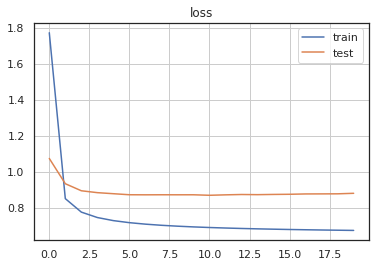

In [13]:
model_dir = "./model_mf"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction

In [14]:
pred = model_mf.predict(te_x).ravel()
print('Shape of test data: ', pred.shape)

Shape of test data:  (30605,)


# Metrics
* 定義4分以上為正向評價, 4分以下為負向評價

## RMSE 

In [15]:
print("RMSE: ", np.sqrt(np.mean((pred - te_y.ravel())**2)))

RMSE:  0.9323054559929994


## AUC

auc: 0.7454575637589687


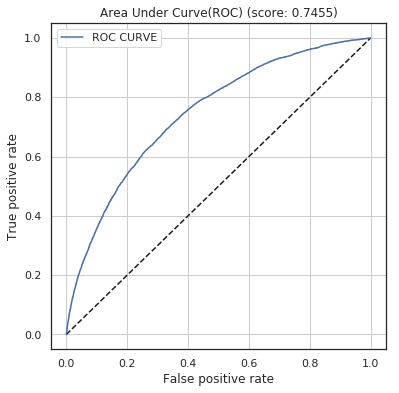

In [16]:
def draw_roc_curve(y, pred_proba):
    fpr, tpr, _ = roc_curve(y, pred_proba, pos_label=1)
    auc_scr = auc(fpr, tpr)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.grid(True)
    plt.show()
    
draw_roc_curve(te.rating >= 4, pred / pred.max())

## Single User Rating Histogram

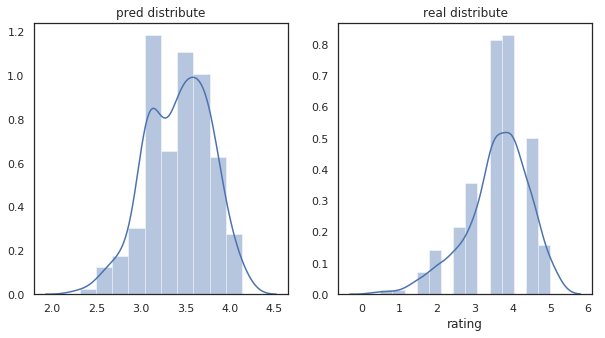

In [17]:
# user id from 0 ~ 670
uid = 22
tmp = te.query(f"userId == {uid}")
single_pred = model_mf.predict(
    [np.repeat(uid, len(tmp.movieId))[:, None],
     tmp.movieId[:, None],
     np.zeros([len(tmp.movieId), 1])]).ravel()

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
sns.distplot(single_pred, ax=ax[0])
ax[1].set_title("real distribute")
sns.distplot(te.query(f"userId == '{uid}'").rating, ax=ax[1])
plt.show()

## Single User Detail Table

In [18]:
# user id from 0 ~ 670
uid = 22
tmp = te.query(f"userId == {uid}")
single_pred = model_mf.predict(
    [np.repeat(uid, len(tmp.movieId))[:, None],
     tmp.movieId[:, None],
     np.zeros([len(tmp.movieId), 1])]).ravel()

recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": tmp.movieId,
              "title": mid_map[tmp.movieId].values,
              "rating": tmp.rating.values,
              "predRating": single_pred},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.sort_values("rating", ascending=False)

,userId,movieId,title,rating,predRating
1265,22,4855,Kill Bill: Vol. 1 (2003),5.0,3.682109
1311,22,6132,Crash (2004),5.0,3.694832
1297,22,5623,Undertow (2004),5.0,3.113887
1248,22,4417,Catch Me If You Can (2002),5.0,3.876078
1249,22,4419,"Hours, The (2002)",5.0,3.587940
1304,22,5761,Duel (1971),5.0,3.578568
1280,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,3.604270
1252,22,4432,City of God (Cidade de Deus) (2002),5.0,4.132617
1231,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.649475
1268,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,3.106828


In [19]:
recommDf.sort_values("predRating", ascending=False)

,userId,movieId,title,rating,predRating
1247,22,4411,My Neighbor Totoro (Tonari no Totoro) (1988),4.5,4.138159
1252,22,4432,City of God (Cidade de Deus) (2002),5.0,4.132617
1418,22,6042,Howl's Moving Castle (Hauru no ugoku shiro) (2...,3.5,4.131116
1286,22,5127,Eternal Sunshine of the Spotless Mind (2004),4.5,4.129736
1250,22,4422,"Pianist, The (2002)",4.5,4.080928
1340,22,4231,Spirited Away (Sen to Chihiro no kamikakushi) ...,3.5,4.065094
1326,22,6383,V for Vendetta (2006),4.5,4.005020
1383,22,5014,"Night at the Opera, A (1935)",3.5,3.994454
1282,22,5026,"Lord of the Rings: The Return of the King, The...",4.5,3.968369
1431,22,6294,Harry Potter and the Goblet of Fire (2005),3.0,3.964452


## Precision@K (K = 10)

### Before Computing Precision@K, See the Count Plot Below First

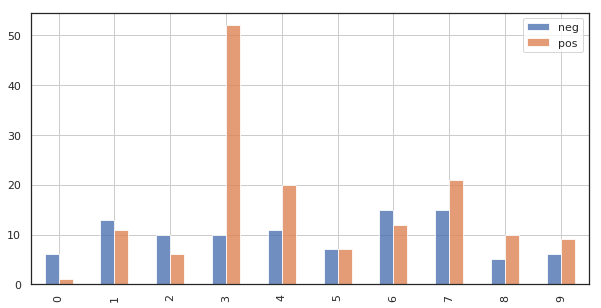

In [20]:
pos_ary, neg_ary = [], []
for label in te_rating_mat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], 
              "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.grid(True)
    plt.show()

draw_pos_neg(np.arange(len(te_rating_mat))[0:10])

### Observations
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也只得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高

In [21]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

_ = sum(np.sum(te_rating_mat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in te_rating_mat)))
print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in te_rating_mat)))

266 個user正向評價總數小於10!
rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


In [0]:
def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

In [23]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
print( "strict condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, norm_condition, k=10) )

strict condition precision at 10:  0.5033492822966508
norm condition precision at 10:  0.6334828101644245


## NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [0]:
def all_user_ndcg(label_mat, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(label_mat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return ndcg_score(label, score, k)

def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k"""
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k"""
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

In [25]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
strict_ndcg = all_user_ndcg(te_rating_mat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(te_rating_mat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

strict condition ndcg at 10:  0.6287350926282057
norm condition ndcg at 10:  0.7621134407170157


<br/>
<br/>
<br/>

# (LAB) 將Model從Regression改為Classification

## 修改Label 為 0, 1 (rating >= 4: 1,  rating < 4: 0)

In [0]:
tr_x = [tr.userId[:, None], 
        tr.movieId[:, None], 
        np.zeros([len(tr), 1])]
tr_y = (tr.rating >= 4).astype(int)[:, None]
# -----------------------------------------------------------------------
te_x = [te.userId[:, None],
        te.movieId[:, None],
        np.zeros([len(te), 1])]
te_y = (te.rating >= 4).astype(int)[:, None]

print('train label:\n', tr_y.ravel()[:10])
print('valid label:\n', te_y.ravel()[:10])

In [0]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    # Bias terms
    b_user = Flatten()(Embedding(n_users, 1, 
                                 embeddings_initializer='glorot_uniform', 
                                 name='b_user')(inp_user))
    b_movie = Flatten()(Embedding(n_movies, 1, 
                                  embeddings_initializer='glorot_uniform', 
                                  name='b_movie')(inp_movie))
    b_global = Flatten()(Embedding(1, 1, 
                                   embeddings_initializer='glorot_uniform', 
                                   name='b_global')(inp_global))
    # Implements the formulation
    nets = dot([emb_user, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    # nets = ...
    ###### END CODE HERE ######
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001 ...
###### END CODE HERE ######

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)

In [0]:
###### START CODE HERE ######
# Hint: recap the loss function of classification
# model_mf.compile(...)
###### END CODE HERE ######

model_dir = "./model_mf_cls"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

## AUC

In [0]:
pred = model_mf.predict(te_x).ravel()
print('Shape of test data: ', pred.shape)

In [0]:
draw_roc_curve(te_y, pred)

## Confusion Matrix, Classification Report, Accuracy

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

print('accuracy_score: ', accuracy_score(te_y, pred >= 0.5))
print(confusion_matrix(te_y.ravel(), pred >= 0.5))
print()
print(classification_report(te_y.ravel(), pred >= 0.5))

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

In [0]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    # Bias terms
    b_user = Flatten()(Embedding(n_users, 1, 
                                 embeddings_initializer='glorot_uniform', 
                                 name='b_user')(inp_user))
    b_movie = Flatten()(Embedding(n_movies, 1, 
                                  embeddings_initializer='glorot_uniform', 
                                  name='b_movie')(inp_movie))
    b_global = Flatten()(Embedding(1, 1, 
                                   embeddings_initializer='glorot_uniform', 
                                   name='b_global')(inp_global))
    # Implements the formulation
    nets = dot([emb_user, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    ###### START CODE HERE ######
    # Modify the model prediction to 0 ~ 1, hint: add an activation function
    nets = Activation('sigmoid')(nets)
    ###### END CODE HERE ######
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 20
lr = 0.1

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)
model_mf.compile(Adagrad(lr=lr), 'binary_crossentropy')

model_dir = "./model_mf_cls"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf.predict(te_x).ravel()

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_y, pred / pred.max())

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report
print('accuracy_score: ', accuracy_score(te_y, pred >= 0.5))
print(confusion_matrix(te_y.ravel(), pred >= 0.5))
print()
print(classification_report(te_y.ravel(), pred >= 0.5))

<br/>
<br/>
<br/>

# (LAB) 延續Classification, 以DNN作法取代MF作法

* Concatenate [user, movie], 且用 dense layer 增加hidden layers

In [0]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers, maybe you need Dropout!
    # nets = Concatenate(1)([emb_user, emb_movie])
    # nets = Dense(...)(nets)
    # ...
    nets = Dense(1, activation='sigmoid')(nets)
    ###### END CODE HERE ######
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

###### START CODE HERE ######
# Modify the hyper parameters to get even better result
emb_size = # 8, 10, 16 ...
reg = # 0.01, 0.005, 0.0005 ...
batch_size = 128
epochs =  # 10, 20 , 30 ...
lr = # 0.1, 0.05, 0.001
###### END CODE HERE ######

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
# model_mf.compile(...)
###### END CODE HERE ######

model_dir = "./model_mf_cls"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)
sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf.predict(te_x).ravel()

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_y, pred / pred.max())

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report
print('accuracy_score: ', accuracy_score(te_y, pred >= 0.5))
print(confusion_matrix(te_y.ravel(), pred >= 0.5))
print()
print(classification_report(te_y.ravel(), pred >= 0.5))

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Solution

In [0]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    ###### START CODE HERE ######
    # Concatenate the user and movie embedding, add 2 hidden layers
    nets = Concatenate(1)([emb_user, emb_movie])
    nets = Dropout(0.5)(nets)
    nets = Dense(16, activation='relu')(nets)
    nets = Dropout(0.5)(nets)
    nets = Dense(8, activation='relu')(nets)
    nets = Dropout(0.5)(nets)
    nets = Dense(1, activation='sigmoid')(nets)
    ###### END CODE HERE ######
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

###### START CODE HERE ######
emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 20
lr = 0.1
###### END CODE HERE ######

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)

###### START CODE HERE ######
# Find best optimizer, e.g: Adam, SGD, Adagrad, find proper loss function
model_mf.compile(SGD(lr=lr), 'binary_crossentropy')
###### END CODE HERE ######

model_dir = "./model_mf_cls"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)
sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction
pred = model_mf.predict(te_x).ravel()

# AUC
print('Shape of test data: ', pred.shape)
draw_roc_curve(te_y, pred / pred.max())

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report
print('accuracy_score: ', accuracy_score(te_y, pred >= 0.5))
print(confusion_matrix(te_y.ravel(), pred >= 0.5))
print()
print(classification_report(te_y.ravel(), pred >= 0.5))